# Preprocessing

> ...

In [1]:
#| default_exp preprocessing

In [2]:
%load_ext autoreload
%autoreload 2

In [32]:
#| export
from pathlib import Path
from tqdm import tqdm

from lssm.loading import load_ossl
from lssm.visualization import plot_spectra

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d


## Scikit-learn transformers

In [33]:
#| export
class ToAbsorbance(BaseEstimator, TransformerMixin):
    """Transform Reflectance to Absorbance"""
    def __init__(self, eps=1e-5): self.eps = eps
    def fit(self, X, y=None): return self
    def transform(self, X, y=None): 
        X[X < 0] = 0
        return -np.log10(X + self.eps)

Example: 

In [52]:
#|eval: false
fname_ossl = Path.home() / 'pro/data/ossl/gcs_version/ossl_all_L0_v1.2.csv.gz'
analytes = 'k.ext_usda.a725_cmolc.kg'

data = load_ossl(fname_ossl, analytes, spectra_type='visnir')
X, y, X_names, smp_idx, ds_name, ds_label = data

<Figure size 640x480 with 0 Axes>

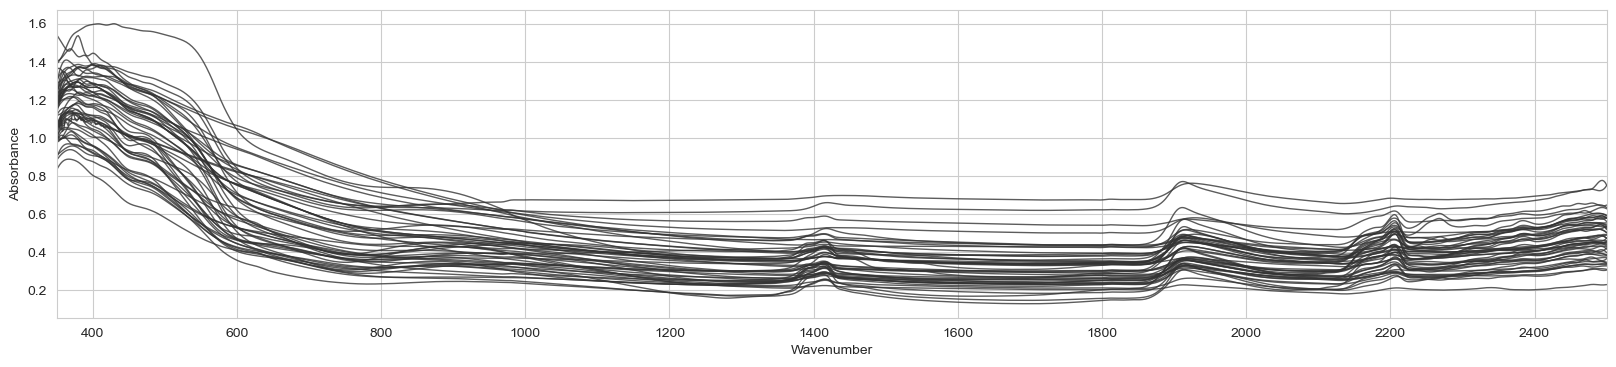

In [53]:
#|eval: false
plot_spectra(ToAbsorbance().fit_transform(X), X_names)

In [28]:
#| export
class ContinuumRemoval(BaseEstimator, TransformerMixin):
    """Creates continnum removal custom transformer"""

    def __init__(self, wls):
        self.wls = wls

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        continuum_removed_spectra = np.zeros_like(X)
        
        for i, spectrum in enumerate(tqdm(X)):
            points = np.c_[self.wls, spectrum]
            x, y = points.T 
            # trick to exclude lower part of convex hull 
            augmented = np.concatenate([points, [(x[0], np.max(y)+1), (x[-1], np.max(y)+1)]], axis=0)
            hull = ConvexHull(augmented)
            continuum_points = points[np.sort([v for v in hull.vertices if v < len(points)])]
            continuum_function = interp1d(*continuum_points.T)
            continuum_removed_spectra[i, :] = y / continuum_function(x)
    
        return continuum_removed_spectra

Example:

100%|██████████| 3725/3725 [00:01<00:00, 2899.54it/s]


<Figure size 640x480 with 0 Axes>

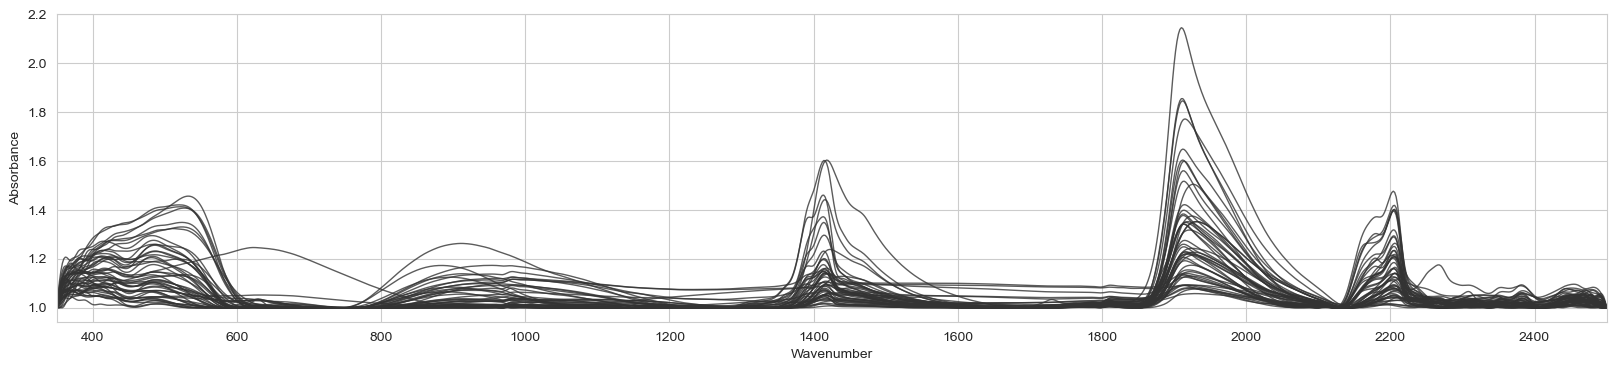

In [56]:
#|eval: false
pipe = Pipeline([('to_abs', ToAbsorbance()), 
                 ('cr', ContinuumRemoval(X_names))])
plot_spectra(pipe.fit_transform(X), X_names)

In [57]:
#|export
class SNV(BaseEstimator, TransformerMixin):
    """Creates scikit-learn SNV custom transformer"""
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        mean, std = np.mean(X, axis=1).reshape(-1, 1), np.std(X, axis=1).reshape(-1, 1)
        return (X - mean)/std

100%|██████████| 3725/3725 [00:01<00:00, 2922.38it/s]


<Figure size 640x480 with 0 Axes>

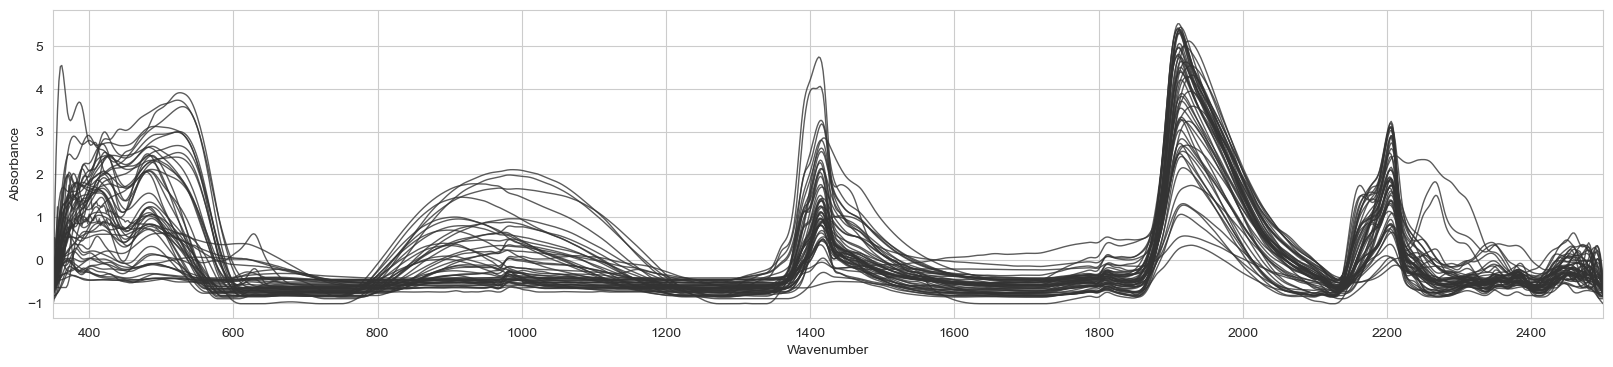

In [58]:
#|eval: false
pipe = Pipeline([('to_abs', ToAbsorbance()),
                 ('cr', ContinuumRemoval(X_names)),
                 ('snv', SNV())])
plot_spectra(pipe.fit_transform(X), X_names)

## Outlier detection